In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from utility import *

### Data loading

In [4]:
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = to_categorical(np.ravel(y_train))
y_test = to_categorical(np.ravel(y_test))

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')

label_names = {
    0: 'plane',
    1: 'car',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)


In [5]:
def preprocess_images(images_set):
    return images_set * 1. / 255   

# Neural Network

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=25,
    horizontal_flip=True,
    vertical_flip=False,
    featurewise_center=True,
    featurewise_std_normalization=True,
    #zca_whitening=True,
    fill_mode='reflect',
    validation_split=0.02
)

train_datagen.fit(x_train)

In [17]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow_addons.layers.maxout import Maxout

def maxout_nn_model(show_summary=False):
    inputs = tf.keras.layers.Input((32, 32, 3))
    
    hidden = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    hidden = tf.keras.layers.MaxPool2D((2,2))(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = Maxout(num_units=32)(hidden)
        
    hidden = tf.keras.layers.Conv2D(96, (3, 3), activation='relu', padding='same')(hidden)
    hidden = tf.keras.layers.MaxPool2D((2,2))(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    #hidden = tf.keras.layers.Dropout(0.1)(hidden)
    hidden = Maxout(num_units=48)(hidden)
    
    hidden = tf.keras.layers.Conv2D(192, (3, 3), activation='relu', padding='same')(hidden)
    hidden = tf.keras.layers.MaxPool2D((2,2))(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    #hidden = tf.keras.layers.Dropout(0.1)(hidden)
    hidden = Maxout(num_units=96)(hidden)
    
    hidden = tf.keras.layers.Conv2D(384, (4, 4), activation='relu', padding='valid')(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    #hidden = tf.keras.layers.Dropout(0.1)(hidden)
    hidden = Maxout(num_units=192)(hidden)
    
    hidden = tf.keras.layers.Flatten()(hidden)
    
    hidden = tf.keras.layers.Dense(256, activation='relu')(hidden)
    hidden = Maxout(num_units=128)(hidden)
    
    outputs = tf.keras.layers.Dense(10, activation='softmax')(hidden)
    
    model = tf.keras.Model(inputs, outputs)
    metrics = [
        tfa.metrics.F1Score(num_classes=10, average="weighted"),
        'accuracy'
    ]
    model.compile(
        optimizer=RMSprop(learning_rate=0.0002),
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    if show_summary:
        print(model.summary())
    
    return model

In [18]:
model = maxout_nn_model(show_summary=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
maxout_5 (Maxout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 96)        27744     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 96)          0   

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

save_best = ModelCheckpoint('models/best_weights_final.hdf5', save_best_only=True, monitor='val_f1_score', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', mode='max', factor=0.2, patience=5, verbose=1, cooldown=3)

history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=64, subset='training'),
    steps_per_epoch=765,
    validation_data=train_datagen.flow(x_train, y_train, batch_size=64, subset='validation'),
    validation_steps=16,
    callbacks=[save_best, reduce_lr],
    epochs=40
)

Epoch 1/40
765/765 [==============================] - 63s 80ms/step - loss: 1.4159 - f1_score: 0.4934 - accuracy: 0.4961 - val_loss: 1.1951 - val_f1_score: 0.5794 - val_accuracy: 0.5790
Epoch 2/40
765/765 [==============================] - 60s 79ms/step - loss: 1.0900 - f1_score: 0.6112 - accuracy: 0.6129 - val_loss: 1.0450 - val_f1_score: 0.6244 - val_accuracy: 0.6270
Epoch 3/40
765/765 [==============================] - 62s 81ms/step - loss: 0.9501 - f1_score: 0.6622 - accuracy: 0.6633 - val_loss: 0.9449 - val_f1_score: 0.6481 - val_accuracy: 0.6510
Epoch 4/40
765/765 [==============================] - 62s 81ms/step - loss: 0.8528 - f1_score: 0.6994 - accuracy: 0.7003 - val_loss: 0.8535 - val_f1_score: 0.7128 - val_accuracy: 0.7150
Epoch 5/40
765/765 [==============================] - 65s 85ms/step - loss: 0.7851 - f1_score: 0.7231 - accuracy: 0.7237 - val_loss: 0.8093 - val_f1_score: 0.7108 - val_accuracy: 0.7110
Epoch 6/40
765/765 [==============================] - 65s 85ms/step - 

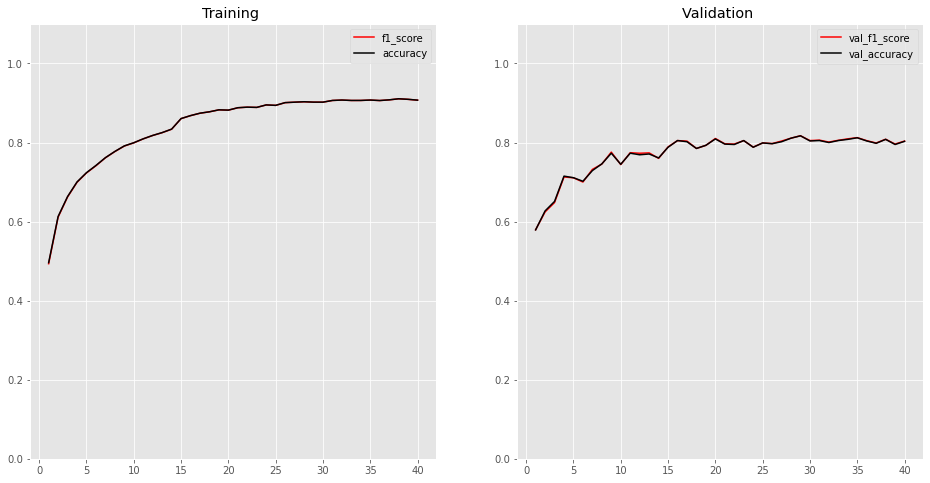

In [24]:
%matplotlib inline
plot_history(history.history)

In [26]:
model.load_weights('models/best_weights_final.hdf5')

test_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)
test_datagen.fit(x_train)

model.evaluate(test_datagen.flow(x_test, y_test))

313/313 [==============================] - 5s 14ms/step - loss: 0.6220 - f1_score: 0.8049 - accuracy: 0.8069


[0.6219919323921204, 0.804894208908081, 0.8069000244140625]